In [2]:
%matplotlib inline
import os
import re
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [ ]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [ ]:
def is_binary(series, allow_na=False):
    if allow_na:
        series.dropna(inplace=True)
    return sorted(series.unique()) == [0, 1]

In [ ]:
RE_EMAIL = re.compile(
    r"(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*)@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])")
RE_URL = re.compile(r"((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/?)*")
RE_RELAX_PHONE = re.compile('(\(? ?[\d]{2,3} ?\)?.{,3}?){2,}')
# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line matches the regular expression "^[\s]*---*[\s]*$".
RE_SEPARATOR = re.compile('^[\s]*---*[\s]*')
RE_REPLY = re.compile('^\>')
RE_REPLY_PUNCT = re.compile('^[^A-Za-z0-9]{1,2}\>')
RE_TAB = re.compile('\t')
RE_WROTE = re.compile('\s(wr[oi]tes?:)$')

# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line has a sequence of 10 or more special characters.
RE_SPECIAL_CHARS = re.compile(('^[\s]*([\*]|#|[\+]|[\^]|-|[\~]|[\&]|[\$]|_|[\!]|'
                               '[\/]|[\%]|[\:]|[\=]){10,}[\s]*$'))

RE_SIGNATURE_WORDS = re.compile(('(T|t)hank.*,|(B|b)est|(R|r)egards|'
                                 '^sent[ ]{1}from[ ]{1}my[\s,!\w]*$|BR|(S|s)incerely|'
                                 '(C|c)orporation|Group'))

# Taken from:
# http://www.cs.cmu.edu/~vitor/papers/sigFilePaper_finalversion.pdf
# Line contains a pattern like Vitor R. Carvalho or William W. Cohen.
RE_NAME = re.compile('[A-Z][a-z]+\s\s?[A-Z][\.]?\s\s?[A-Z][a-z]+')


def punct_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c in string.punctuation]
    return len(punct) / len(line)


def alphanum_percent(line):
    if len(line) == 0:
        return 0
    punct = [c for c in line if c.isalnum()]
    return len(punct) / len(line)

In [ ]:
feature_dict = {
        'email': lambda doc: 1 if RE_EMAIL.search(doc[0]) else 0,
        'url': lambda doc: 1 if RE_URL.search(doc[0]) else 0,
        'phone': lambda doc: 1 if RE_RELAX_PHONE.search(doc[0]) else 0,
        'sigdelimiter': lambda doc: 1 if RE_SEPARATOR.match(doc[0]) else 0,
        'special': lambda doc: 1 if RE_SPECIAL_CHARS.search(doc[0]) else 0,
        'words': lambda doc: 1 if RE_SIGNATURE_WORDS.search(doc[0]) else 0,
        'name': lambda doc: 1 if RE_NAME.search(doc[0]) else 0,
        'endquote': lambda doc: 1 if doc[0].endswith("\"") else 0,
        'tabs1': lambda doc: 1 if len(RE_TAB.findall(doc[0])) == 1 else 0,
        'tabs2': lambda doc: 1 if len(RE_TAB.findall(doc[0])) == 2 else 0,
        'tabs3': lambda doc: 1 if len(RE_TAB.findall(doc[0])) >= 3 else 0,
        'punct20': lambda doc: 1 if punct_percent(doc[0]) >= 0.2 else 0,
        'punct50': lambda doc: 1 if punct_percent(doc[0]) >= 0.5 else 0,
        'punct90': lambda doc: 1 if punct_percent(doc[0]) >= 0.9 else 0,
        'reply': lambda doc: 1 if RE_REPLY.match(doc[0]) else 0,
        'startpunct': lambda doc: 1 if doc[0].startswith(tuple(p for p in string.punctuation)) else 0,
        'firstchar': lambda doc: doc[0][0] if len(doc[0]) > 0 else "",
        'replypunct': lambda doc: 1 if RE_REPLY_PUNCT.match(doc[0]) else 0,
        'wrote': lambda doc: 1 if RE_WROTE.search(doc[0]) else 1,
        'alphanum90': lambda doc: 1 if alphanum_percent(doc[0]) < 0.9 else 0,
        'alphanum50': lambda doc: 1 if alphanum_percent(doc[0]) < 0.5 else 0,
        'alphanum10': lambda doc: 1 if alphanum_percent(doc[0]) < 0.1 else 0,
        'title': lambda doc: 1 if doc[0].strip().istitle() else 0
    }

In [463]:
list_entities = ["greeting", "signature"]
ENTITY_PATTERN = r"(\[)(?P<line>.+)(\])\((?P<entity>" + "|".join(list_entities) +")\)"

In [464]:
def remove_blanks(lines):    
    return [line for line in lines if len(line.strip()) > 0]

In [615]:
def line_to_entity(line, filename, i):
    m = re.match(ENTITY_PATTERN, line)
    if m:
        e = {
            "line": m.group("line"),
            "filename": filename,
            "entity": m.group("entity"),
            "len": len(m.group("line")),
            "lineNo": i+1
        }
    else:
        e = {"line": line, "filename": filename, "entity": "no_entity", "len": len(line), "lineNo": i+1}    
    doc = tuple((e["line"],))
    for feature, fn in feature_dict.items():            
        e[feature] = fn(doc)    
    return e

In [616]:
def get_signature_length(ents):
    """ Signature length in number of lines """
    return sum(1 for e in ents if e["entity"] == "signature")

In [617]:
files_path = os.path.join(os.path.abspath(''), r"../../data/signature_train_set_en")
filenames = [f for f in os.listdir(files_path) if os.path.isfile(os.path.join(files_path, f))]

In [618]:
files = list()
entities = list()
for filename in filenames:
    with open(os.path.join(files_path, filename), mode="r", encoding="utf-8") as f:
        lines = f.read().splitlines()
        non_blanks = remove_blanks(lines)
        lengths = [len(line) for line in non_blanks]
        file_entities = [line_to_entity(line, filename, i) for i, line in enumerate(non_blanks)]
        entities.extend(file_entities)
        files.append({
            "filename": filename,
            "nlines": len(lines),
            "len_avg": np.ceil(np.mean(lengths)),
            "len_min": min(lengths),
            "len_max": max(lengths),
            "nBlanks": len(lines) - len(non_blanks),
            "nNonBlanks": len(non_blanks),
            "nSig": get_signature_length(file_entities)
        })
        
df_files = pd.DataFrame(files) 
entities = pd.DataFrame(entities)

In [620]:
master = entities.merge(df_files, on="filename")

In [621]:
master.iloc[100:110,]

,line,filename,entity,len,lineNo,email,url,phone,sigdelimiter,special,...,alphanum50,alphanum10,title,nlines,len_avg,len_min,len_max,nBlanks,nNonBlanks,nSig
100,> bcn.1531.grupo2@bcdtravel.es <bacelona.290.g...,alt_deutz_15_body.md,no_entity,64,35,1,1,1,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12
101,> www.bcdtravel.es,alt_deutz_15_body.md,no_entity,18,36,0,1,0,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12
102,>,alt_deutz_15_body.md,no_entity,1,37,0,0,0,0,0,...,1,1,0,2649,20.0,1,88,1341,1308,12
103,> image: BCD Travel,alt_deutz_15_body.md,no_entity,19,38,0,0,0,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12
104,>,alt_deutz_15_body.md,no_entity,1,39,0,0,0,0,0,...,1,1,0,2649,20.0,1,88,1341,1308,12
105,>,alt_deutz_15_body.md,no_entity,1,40,0,0,0,0,0,...,1,1,0,2649,20.0,1,88,1341,1308,12
106,"> *Le informamos que BCD Travel, dispone de un...",alt_deutz_15_body.md,no_entity,68,41,0,0,0,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12
107,> atención para emergencias fuera del horario...,alt_deutz_15_body.md,no_entity,76,42,0,0,0,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12
108,> través del teléfono 902995365 (llamadas naci...,alt_deutz_15_body.md,no_entity,59,43,0,0,1,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12
109,> 971070551 (llamadas desde el extranjero). Es...,alt_deutz_15_body.md,no_entity,75,44,0,0,1,0,0,...,0,0,0,2649,20.0,1,88,1341,1308,12


In [622]:
entities.shape

(7179, 28)

In [623]:
master.shape

(7179, 35)

In [624]:
master.dtypes

line             object
filename         object
entity           object
len               int64
lineNo            int64
email             int64
url               int64
phone             int64
sigdelimiter      int64
special           int64
words             int64
name              int64
endquote          int64
tabs1             int64
tabs2             int64
tabs3             int64
punct20           int64
punct50           int64
punct90           int64
reply             int64
startpunct        int64
firstchar        object
replypunct        int64
wrote             int64
alphanum90        int64
alphanum50        int64
alphanum10        int64
title             int64
nlines            int64
len_avg         float64
len_min           int64
len_max           int64
nBlanks           int64
nNonBlanks        int64
nSig              int64
dtype: object

# More features

In [845]:
master["posFromEnd"] = master.nNonBlanks - master.lineNo
master["last"] = master.posFromEnd.apply(lambda x: 1 if x == 0 else 0)
master["prevlast"] = master.posFromEnd.apply(lambda x: 1 if x == 1 else 0)
master["last5"] = master.posFromEnd.apply(lambda x: 1 if x < 5 else 0)
master["last11"] = master.posFromEnd.apply(lambda x: 1 if x < 11 else 0)
master["posRatio"] = master.lineNo / master.nlines # 1 = last
master["posRatioNB"] = master.lineNo / master.nNonBlanks # 1 = last
master["lenRatio"] = master.len / master.len_avg

In [953]:
master["less_avg_len"] = master.apply(lambda row: 1 if row.len <= row.len_avg else 0, axis=1)
master["more_avg_len"] = master.apply(lambda row: 1 if row.len > row.len_avg else 0, axis=1)
master["less_avg_len75"] = master.apply(lambda row: 1 if row.len <= (row.len_avg*.75) else 0, axis=1)
master["less_avg_len50"] = master.apply(lambda row: 1 if row.len <= (row.len_avg*.5) else 0, axis=1)

In [987]:
master["hasCid"] = master.apply(lambda row: 1 if "cid:" in row.line else 0, axis=1)

In [954]:
master.loc[0:12:,("line", "posFromEnd", "last", "prevlast", "last5", "last11", "posRatio", "posRatioNB", "len", "len_avg", "lenRatio")]

,line,posFromEnd,last,prevlast,last5,last11,posRatio,posRatioNB,len,len_avg,lenRatio
0,"Good afternoon,",11,0,0,0,0,0.029412,0.083333,15,35.0,0.428571
1,i would like to book one double room with single beds with private bathroom,10,0,0,0,1,0.058824,0.166667,75,35.0,2.142857
2,and with breakfast included from 26/08 to 30/08.,9,0,0,0,1,0.088235,0.250000,48,35.0,1.371429
3,Could you please tell me the total ammount?,8,0,0,0,1,0.117647,0.333333,43,35.0,1.228571
4,Thank you.,7,0,0,0,1,0.147059,0.416667,10,35.0,0.285714
5,Giulia Gobbi,6,0,0,0,1,0.176471,0.500000,14,35.0,0.400000
6,LAPROGEMA SRL,5,0,0,0,1,0.205882,0.583333,13,35.0,0.371429
7,"Via Rocco Chinnici, 22",4,0,0,1,1,0.235294,0.666667,22,35.0,0.628571
8,61040 Monte Porzio (PU),3,0,0,1,1,0.264706,0.750000,23,35.0,0.657143
9,P.iva 02504710415,2,0,0,1,1,0.294118,0.833333,17,35.0,0.485714


In [997]:
master.sample(10).loc[:,("len", "len_avg", "less_avg_len", "more_avg_len", "line", "hasCid")]

,len,len_avg,less_avg_len,more_avg_len,line,hasCid
3835,1,58.0,1,0,|,0
308,29,20.0,0,1,">> *Mit freundlichen Grüßen,*",0
3540,55,44.0,0,1,<http://www.wayfairprofessional.com/?refid=WFRProEmail>,0
6133,142,115.0,0,1,From Cologne / Bonn Airport take the airport shuttle bus to station: Köln-Deutz (from there it takes about 3-5 minutes to the hotel on foot).,0
647,19,20.0,1,0,>> www.bcdtravel.es,0
3717,9,40.0,1,0,JacTravel,0
1937,32,94.0,1,0,________________________________,0
3636,19,33.0,1,0,*Other Information*,0
431,2,20.0,1,0,>>,0
1855,74,36.0,0,1,I would like to inquire for a single room at Ameron hotel Regent Köln with,0


In [998]:
all_features = feature_dict.keys() | ["last", "prevlast", "last5", "last11"]

In [999]:
signatures = master[master.entity == "signature"]

# Where are the signatures in the text?

In [1000]:
# Median file length
print(f"Median file length: {np.median(master.nNonBlanks)}")
print(f"Average file length: {np.mean(master.nNonBlanks)}")

Median file length: 25.0
Average file length: 277.66276640200584


In [1001]:
# Signature length in number of lines
print(f"Median signature length: {master.nSig.median()} lines")
print(f"Mean signature length: {master.nSig.mean()} lines")

Median signature length: 11.0 lines
Mean signature length: 12.865162278868922 lines


In [1002]:
master.nSig.median() / master.nlines.median() # the median signature is 15% of the median file (all lines)

0.14666666666666667

In [1003]:
master.nSig.median() / master.nNonBlanks.median() # the median signature is 44% of the median file (non-blank lines)

0.44

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000120C280A208>]],
      dtype=object)

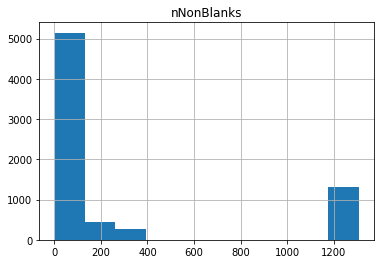

In [1004]:
master.hist(column="nNonBlanks")

In [1005]:
noreplies = master[~master.line.str.startswith(">")]

In [1006]:
# Median file length without replies
print(f"Median file length: {np.median(noreplies.nNonBlanks)}")
print(f"Average file length: {np.mean(noreplies.nNonBlanks)}")

Median file length: 18.0
Average file length: 35.882066641707226


😊

In [1007]:
# Line No of signatures
print(f"Median lineNo: {np.median(signatures.lineNo)}")
print(f"Average lineNo: {np.mean(signatures.lineNo)}")

Median lineNo: 12.0
Average lineNo: 19.347972972972972


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000120C293CBA8>]],
      dtype=object)

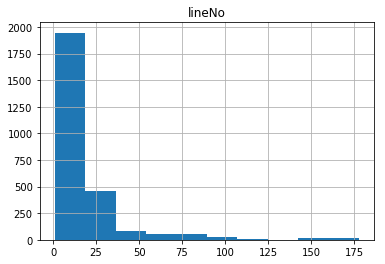

In [1008]:
signatures.hist(column="lineNo")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000120C28CDB00>]],
      dtype=object)

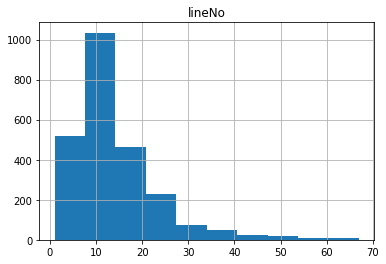

In [1009]:
signatures[signatures.nlines-signatures.nBlanks < 75].hist(column="lineNo")

In [1010]:
signatures.columns

Index(['line', 'filename', 'entity', 'len', 'lineNo', 'email', 'url', 'phone',
       'sigdelimiter', 'special', 'words', 'name', 'endquote', 'tabs1',
       'tabs2', 'tabs3', 'punct20', 'punct50', 'punct90', 'reply',
       'startpunct', 'firstchar', 'replypunct', 'wrote', 'alphanum90',
       'alphanum50', 'alphanum10', 'title', 'nlines', 'len_avg', 'len_min',
       'len_max', 'nBlanks', 'nNonBlanks', 'nSig', 'posFromEnd', 'last',
       'prevlast', 'last5', 'last11', 'posRatio', 'posRatioNB', 'lenRatio',
       'less_avg_len', 'more_avg_len', 'less_avg_len75', 'less_avg_len50',
       'hasCid'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E0723CE848>,
      dtype=object)

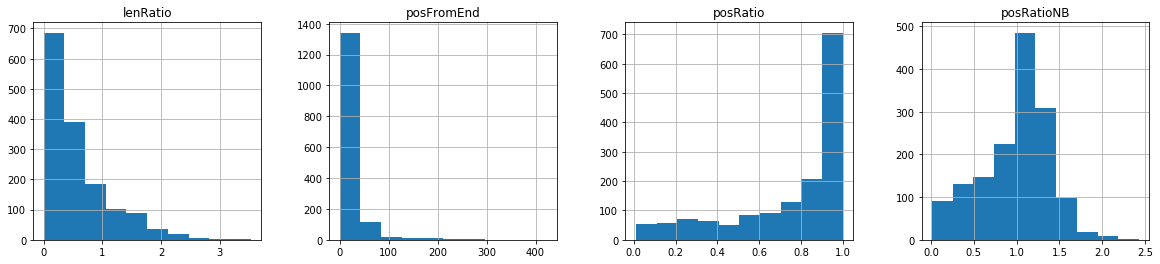

In [6]:
signatures.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

In [1012]:
noentities = master[master.entity=="no_entity"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000120C19B88D0>,
      dtype=object)

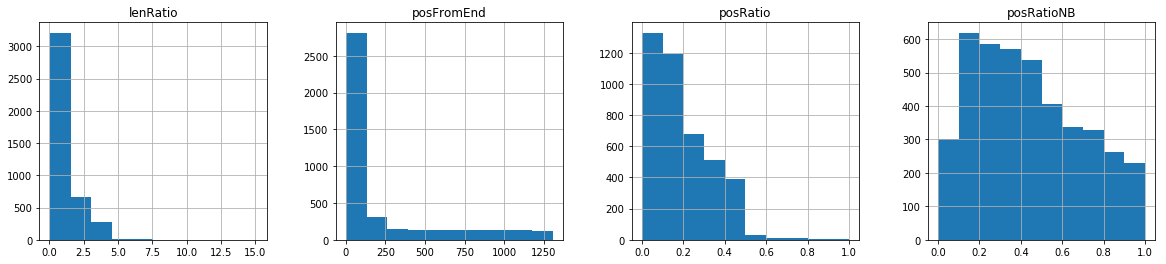

In [1013]:
noentities.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000120C1F0B208>,
      dtype=object)

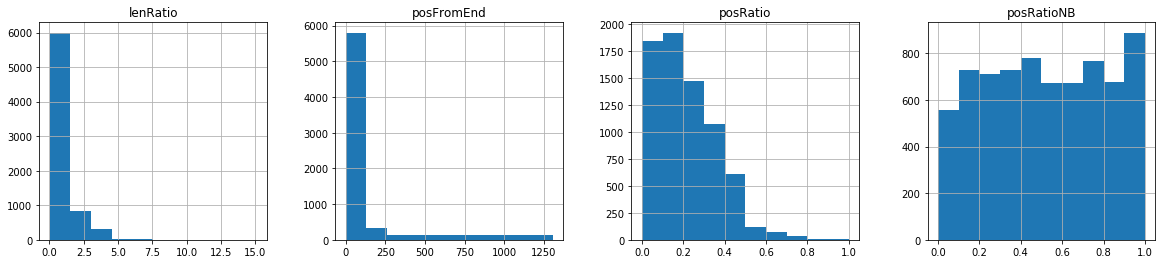

In [1014]:
master.loc[:, ("posRatio", "posRatioNB", "posFromEnd", "lenRatio")].hist(layout=(1,4), figsize=(20,4))

In [1015]:
signatures.len.describe()

count    2664.000000
mean       46.662538
std        83.770392
min         1.000000
25%        14.000000
50%        26.000000
75%        57.000000
max      1215.000000
Name: len, dtype: float64

In [1016]:
noentities.len.describe()

count    4170.000000
mean       41.278657
std        56.010044
min         1.000000
25%         2.000000
50%        29.000000
75%        65.000000
max       789.000000
Name: len, dtype: float64

In [1017]:
signatures.columns

Index(['line', 'filename', 'entity', 'len', 'lineNo', 'email', 'url', 'phone',
       'sigdelimiter', 'special', 'words', 'name', 'endquote', 'tabs1',
       'tabs2', 'tabs3', 'punct20', 'punct50', 'punct90', 'reply',
       'startpunct', 'firstchar', 'replypunct', 'wrote', 'alphanum90',
       'alphanum50', 'alphanum10', 'title', 'nlines', 'len_avg', 'len_min',
       'len_max', 'nBlanks', 'nNonBlanks', 'nSig', 'posFromEnd', 'last',
       'prevlast', 'last5', 'last11', 'posRatio', 'posRatioNB', 'lenRatio',
       'less_avg_len', 'more_avg_len', 'less_avg_len75', 'less_avg_len50',
       'hasCid'],
      dtype='object')

# Features

In [1018]:
signatures.shape

(2664, 48)

In [1019]:
print(f"There are {sum(signatures.email)} email matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.phone)} phone matches out of {len(signatures.index)} signature lines.")
print(f"There are {sum(signatures.name)} name matches out of {len(signatures.index)} signature lines.") # Too low?

There are 123 email matches out of 2664 signature lines.
There are 629 phone matches out of 2664 signature lines.
There are 6 name matches out of 2664 signature lines.


In [1020]:
signatures.columns

Index(['line', 'filename', 'entity', 'len', 'lineNo', 'email', 'url', 'phone',
       'sigdelimiter', 'special', 'words', 'name', 'endquote', 'tabs1',
       'tabs2', 'tabs3', 'punct20', 'punct50', 'punct90', 'reply',
       'startpunct', 'firstchar', 'replypunct', 'wrote', 'alphanum90',
       'alphanum50', 'alphanum10', 'title', 'nlines', 'len_avg', 'len_min',
       'len_max', 'nBlanks', 'nNonBlanks', 'nSig', 'posFromEnd', 'last',
       'prevlast', 'last5', 'last11', 'posRatio', 'posRatioNB', 'lenRatio',
       'less_avg_len', 'more_avg_len', 'less_avg_len75', 'less_avg_len50',
       'hasCid'],
      dtype='object')

In [1021]:
signatures.loc[:, all_features].sum().sort_index()

alphanum10                                                                                                                                                        116
alphanum50                                                                                                                                                        128
alphanum90                                                                                                                                                       2106
email                                                                                                                                                             123
endquote                                                                                                                                                            2
firstchar        LV6PTCKEVWEBAСBMu0+wisRWEK- ZKMHFM-wcBAP0Tbw*pddiBA-*AHG6DTFEwISSUG*EKJCHMEWMRCHIivWDieeiKJCHMEWMRCHIivWDieei LV6PTCKD-****wWNGDHPMTFwPGIYWbL-*LH...
last

In [1022]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column], margins=True))
        cross_tbl_labels.append(column)

In [1023]:
display_side_by_side(cross_tables, cross_tbl_labels)

email,0,1,All
entity,,,
greeting,345,0,345
no_entity,4052,118,4170
signature,2541,123,2664
All,6938,241,7179
url,0,1,All
entity,,,
greeting,345,0,345
no_entity,3913,257,4170
signature,2276,388,2664


In [1066]:
def pvalue_to_star(pval):
    if pval > 0.05: return "ns"
    if pval <= 0.001: return "***"  
    if pval <= 0.01: return "**"
    if pval <= 0.05: return "*"

In [1078]:
from scipy.stats import fisher_exact, chi2_contingency

In [1092]:
chi_tests = list()
print("=== Chi Square Test ===")
for i, table in enumerate(cross_tables):    
    chi2, p, dof, expected = chi2_contingency(table)
    chi_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
chi_tests_df = pd.DataFrame(chi_tests)
chi_tests_df.round(5)

=== Chi Square Test ===


,feature,p_value,significance
0,email,0.10638,ns
1,url,0.00025,***
2,phone,0.00000,***
3,sigdelimiter,0.09159,ns
4,special,0.26329,ns
5,words,0.00088,***
6,name,0.79439,ns
7,endquote,0.94931,ns
8,tabs1,0.93236,ns
9,tabs3,0.95122,ns


In [1094]:
fisher_tests = list()
print("=== Fisher's Exact Test (only for no_entity vs signature) ===")
for i, table in enumerate(cross_tables):
    odds_ratio, p = fisher_exact(table.loc[("no_entity", "signature"),:])
    fisher_tests.append({
        "feature": cross_tbl_labels[i],
        "p_value": p,
        "significance": pvalue_to_star(p)
    })
fisher_tests_df = pd.DataFrame(fisher_tests)
fisher_tests_df.round(5)

=== Fisher's Exact Test (only for no_entity vs signature) ===


,feature,p_value,significance
0,email,0.68267,ns
1,url,0.09682,ns
2,phone,0.60236,ns
3,sigdelimiter,0.49746,ns
4,special,1.00000,ns
5,words,0.01837,*
6,name,1.00000,ns
7,endquote,1.00000,ns
8,tabs1,1.00000,ns
9,tabs3,1.00000,ns


In [1090]:
chi_tests_df[chi_tests_df.p_value < 0.05]

,feature,p_value,significance
5,words,4.483072e-02,*
7,endquote,2.946313e-03,**
8,tabs1,2.139612e-02,*
9,tabs3,2.146691e-05,***
10,punct20,1.145017e-04,***
11,punct50,4.005210e-05,***
12,punct90,2.089042e-05,***
13,reply,2.451238e-13,***
14,startpunct,2.553915e-09,***
15,replypunct,9.642850e-09,***


In [1091]:
fisher_tests_df[fisher_tests_df.p_value < 0.05]

,feature,p_value,significance
5,words,1.837457e-02,*
10,punct20,5.783975e-05,***
11,punct50,1.478803e-05,***
12,punct90,6.964021e-06,***
13,reply,2.486902e-16,***
14,startpunct,4.489630e-10,***
15,replypunct,1.433910e-10,***
16,alphanum90,2.220005e-04,***
17,alphanum50,7.335496e-06,***
18,alphanum10,1.478803e-05,***


In [1059]:
fisher_exact(pd.crosstab(nogreeting.entity, nogreeating.punct20))

(0.20343420190543182, 4.412177856941197e-119)

In [1060]:
pvalue_to_star(4.412177856941197e-119)

'*'

In [1065]:
4.412177856941197e-119 < 0.001

True

In [1053]:
cross_tables = list()
cross_tbl_labels = list()
for column in master.columns:
    if is_binary(master[column]) and column != "entity":
        cross_tables.append(pd.crosstab(master.entity, master[column]).apply(lambda r: round((r/r.sum())*100, 2), axis=1))
        cross_tbl_labels.append(column)
display_side_by_side(cross_tables, cross_tbl_labels)

email,0,1
entity,,
greeting,100,0
no_entity,97.17,2.83
signature,95.38,4.62
url,0,1
entity,,
greeting,100,0
no_entity,93.84,6.16
signature,85.44,14.56
phone,0,1


In [1025]:
master.loc[master.line.str.contains("@") & (master.email == 0), ("line", "email")]

,line,email
56,cid:image001.jpg@01CB7BA1.91B5E840 cid:image005.jpg@01CDD6F2.4AAA8010,0
65,"cid:BE42D4CE-0D06-4FD1-A4F4-89AEED924828@ Before printing this e-mail, please consider environment protection!",0
2728,Descrizione: Descrizione: cid:image001.jpg@01CC3D6D.F0796940,0
3078,PINHACK@HOTELREGENT.DE / PINHACK@AMERONHOTELS.COM,0
3157,cid:image002.png@01D1F237.87C961A0,0
3163,https://pfizermeetings.onyxcentersource.com/registration?email=INFO@HOTELREGENT.DE&vendor=101465,0
3722,E: Marina.Roman@JacTravel.com<mailto:Marina.Roman@JacTravel.com>,0
3725,cid:image001.jpg@01D3DD4E.E2D761B0,0
3758,cid:image001.png@01D44836.96030080<http://www.cherubino.com.mt/>,0
3772,cid:image001.png@01D44836.96030080<http://www.cherubino.com.mt/>,0


In [1035]:
nogreeting = master[master.entity != "greeting"]
pd.crosstab(nogreeting.entity, nogreeting.email).shape

(2, 2)